<a href="https://colab.research.google.com/github/jHrdy/Data/blob/main/house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rukenmissonnier/final-house")

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

plt.style.use("ggplot")

data_list = os.listdir(path)
df = pd.read_csv(os.path.join(path, data_list[0]))

In [45]:
df.head()

,bedroom_count,net_sqm,center_distance,metro_distance,floor,age,price
0,1,26.184098,1286.68,204.003817,22,67,96004.804557
1,1,34.866901,1855.25,186.980360,8,30,92473.722568
2,1,36.980709,692.09,111.224999,24,24,98112.519942
3,1,17.445723,1399.49,237.998760,1,66,92118.326874
4,1,52.587646,84.65,100.996400,20,3,98976.653176


In [46]:
df.iloc[0,0]

1

In [47]:
def plot_x_against_y(x_name, y_name='price'):
    plt.scatter(df[x_name], df[y_name], color='blue')
    plt.title(f'{x_name} vs. {y_name}')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(True)
    plt.show()

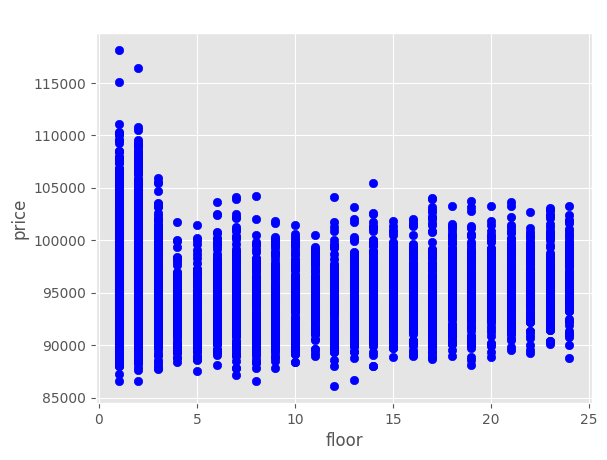

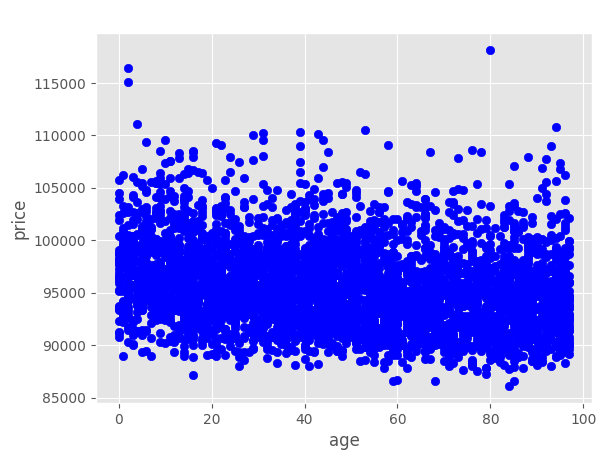

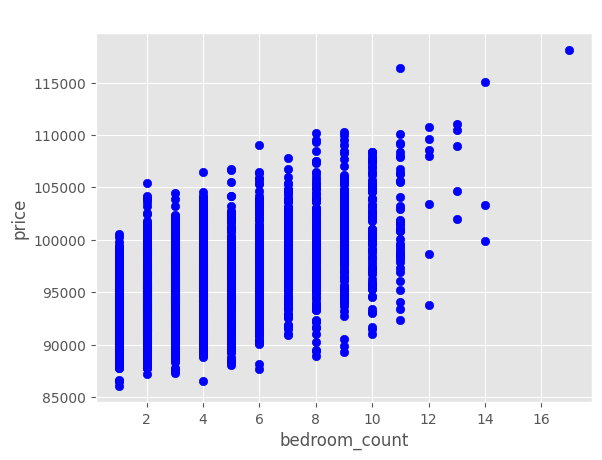

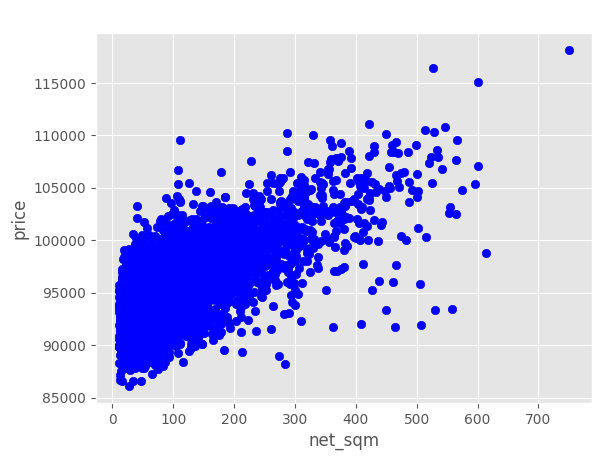

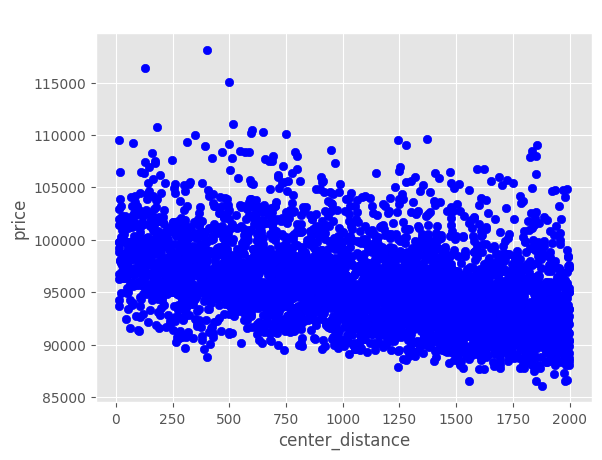

In [48]:
plot_x_against_y('floor')
plot_x_against_y('age')
plot_x_against_y('bedroom_count')
plot_x_against_y('net_sqm')
plot_x_against_y('center_distance')

# First Approach
#### Even though it looks like some parameters do not have major impact on the price we may still try to predict it using all columns.  

In [49]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1,1))


In [62]:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

scaler = MinMaxScaler()
y_test = scaler.fit_transform(y_test.reshape(-1,1))

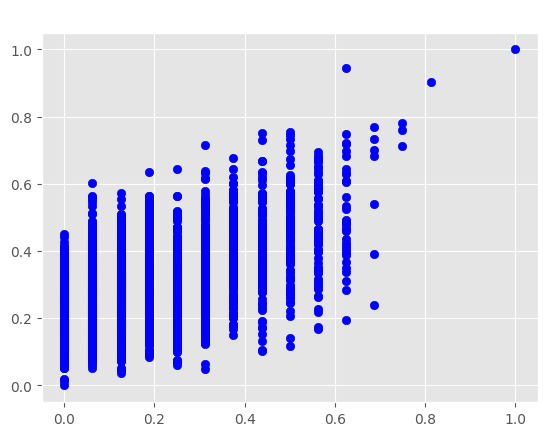

In [51]:
plt.scatter(X_train[:,0], y_train, color='blue')
plt.title(f'bedrooms vs. price')
plt.grid(True)
plt.show()

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [54]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [63]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [103]:
class Predictor(nn.Module):
  def __init__(self, input, h1, h2):
    super(Predictor, self).__init__()
    self.fc1 = nn.Linear(input, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [104]:
model = Predictor(6, 10, 5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [105]:
epochs = 250
losses = []
for ep in range(epochs):
  yhat = model(X_train)
  loss = criterion(yhat,y_train)
  losses.append(loss.detach().numpy())
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  if ep % 50 == 0:
    print(f'Epoch: {ep}, Loss: {loss.detach().numpy()}')

Epoch: 0, Loss: 0.1392880082130432
Epoch: 50, Loss: 0.02407648414373398
Epoch: 100, Loss: 0.015272212214767933
Epoch: 150, Loss: 0.010219603776931763
Epoch: 200, Loss: 0.00747273862361908


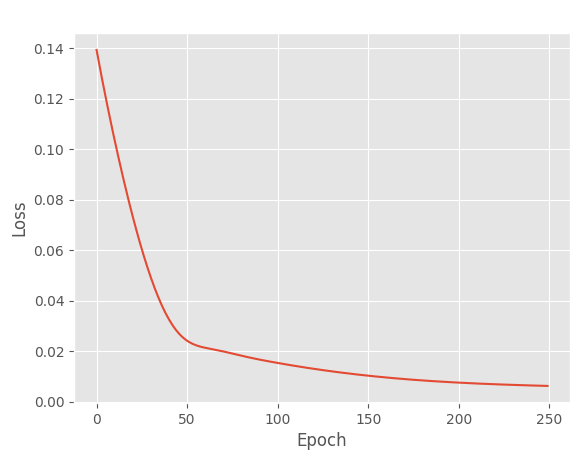

In [106]:
plt.plot(losses)
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [124]:
results = []
test_losses = []
mae = nn.L1Loss()

with torch.no_grad():
  ypred = model(X_test)
  results.append(mae(ypred, y_test).item())
  loss = criterion(ypred, y_test)
  test_losses.append(loss.detach().numpy())
loss = np.mean(test_losses)
print(f'Test Loss: {loss}')

Test Loss: 0.018770433962345123
